
#  Carlos Álvarez

### **Git-hub: https://github.com/Alvarez527**
### **Linkedin: www.linkedin.com/in/cralvarez-ai**

## Advanced Machine Learning Methods


#### Professor: Pepe Cantoral Ph.D.

## **Transformers**
#### Activity 4: Text Generator (Translator)

Created On: Mar 5, 2025 | Last Updated: Mar 15, 2025

## **Instructions**


- Objective

To understand the Transformer Architecture by Implementing a translator.

- Instructions

    This activity requires submission in teams. While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Follow the provided code. The code already implements a transformer from scratch as explained in one of [week's 9 videos](https://youtu.be/XefFj4rLHgU)

    Since the provided code already implements a simple translator, your job for this assignment is to understand it fully, and document it using pictures, figures, and markdown cells.  You should test your translator with at least 10 sentences. The dataset used for this task was obtained from [Tatoeba, a large dataset of sentences and translations](https://tatoeba.org/en/downloads).
  
- Evaluation Criteria

    - Code Readability and Comments
    - Traning a translator
    - Translating at least 10 sentences.

- Submission

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.



# **Solution**

### Script to convert csv to text file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#This script requires to convert the TSV file to CSV
# easiest way is to open it in Calc or excel and save as csv
PATH = '/content/drive/MyDrive/Colab Notebooks/MNA/TC5033 - Advance ML Methods/Week 9/Activity 4/eng-spa2024.csv'
import pandas as pd
df = pd.read_csv(PATH, sep=',', header=None)

In [ ]:
df.head()

,0,1,2,3,4,5
0,1276,Let's try something.,2481,¡Intentemos algo!,NaN,NaN
1,1277,I have to go to sleep.,2482,Tengo que irme a dormir.,NaN,NaN
2,1280,Today is June 18th and it is Muiriel's birthday!,2485,¡Hoy es 18 de junio y es el cumpleaños de Muir...,NaN,NaN
3,1280,Today is June 18th and it is Muiriel's birthday!,1130137,¡Hoy es el 18 de junio y es el cumpleaños de M...,NaN,NaN
4,1282,Muiriel is 20 now.,2487,"Ahora, Muiriel tiene 20 años.",NaN,NaN


In [ ]:
eng_spa_cols = df.iloc[:, [1, 3]]
eng_spa_cols['length'] = eng_spa_cols.iloc[:, 0].str.len()
eng_spa_cols = eng_spa_cols.sort_values(by='length')
eng_spa_cols = eng_spa_cols.drop(columns=['length'])

output_file_path = '/content/drive/MyDrive/Colab Notebooks/MNA/TC5033 - Advance ML Methods/Week 9/Activity 4/eng-spa4.txt'
eng_spa_cols.to_csv(output_file_path, sep='\t', index=False, header=False) # Separate english and spanihs words in each row with a tab

<ipython-input-4-39ed6e6fdc9d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_spa_cols['length'] = eng_spa_cols.iloc[:, 0].str.len()


In [ ]:
eng_spa_cols

,1,3
67760,Hi.,Hola.
152960,So?,¿Entonces?
227950,Go!,Váyase
227951,Go!,Vete
230967,Ok!,¡OK!
...,...,...
145657,As far as I understand despite my limited know...,Hasta donde comprendo a pesar de mi poco conoc...
161608,"Three hours later, the King was loitering arou...","Tres horas después, el rey estaba merodeando p..."
265348,"In Japanese, conjugation is fundamental to pie...","En japonés, la conjugación es fundamental para..."
73306,"There is no such thing, at this stage of the w...","No existe tal cosa, en esta etapa de la histor..."


## Transformer - Attention is all you need

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import math
import numpy as np
import re

torch.manual_seed(23) # To ensure our code execution is reproducible

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
MAX_SEQ_LEN = 128 # To be used as the default maximum tokens allowed in a sentence

### Transformer Model

The transformer architecture serves as a foundation for popular language models like chatGPT. It allows learning long-range contextual relationships within sequences (Dhanani et al., 2025, p. 1). The Transformer models, originally designed for natural language processing tasks, has emerged as a breakthrough in various domains, particularly in computer vision, with significant advancements in image segmentation (Tian et al., 2022, p. 1).


The main elements of a Transformer architecture are self-attention, encoder-decoder and FFNN(Feed Forward neural network). A regular Transformer consists of three parts: encoder, decoder and a final linear layer.The base model of Transformer use 8 attention layers or heads, 512 dimensions of model and 2048 dimensions of Feed Forward (Kumar, 2025, pp. 1438-1439).

The layers considered in the architecture are:
  - **Positional Embedding**: Generates deterministic positional encodings using sine and cosine functions at different frequencies. These encodings are added to the token embeddings, injecting positional information into the model. For each position 𝑖 and embedding dimension 2𝑘 or 2𝑘+1, the encoding is computed as:
  $$
  \text{PE}(i, 2k) = \sin\left(\frac{i}{10000^{\frac{2k}{d_{model}}}}\right)
  $$
  
  $$
  \text{PE}(i, 2k+1) = \cos\left(\frac{i}{10000^{\frac{2k}{d_{model}}}}\right)
  $$

  - **Masking**: Two masking strategies are used:
    * **Padding Mask**: Prevents padded tokens (typically represented by 0) from affecting the attention mechanism by setting their mask values to zero.
    * **Causal (Future) Mask**: Ensures autoregressive behavior in the decoder by disallowing attention to future tokens. This is done by creating a lower triangular matrix where the upper triangle is masked.

  - **Multi-Head Attention**: Breaks down the attention mechanism into multiple parallel heads to capture diverse features:
    * **Linear Projections**: The input embeddings are projected into queries (Q), ke (K), and values (V) via learned linear transformations.
    * **Scaled Dot-Product Attention**: Attention scores are computed using (the factor 𝑑𝑘 scales the dot product to stabilize gradients):
  $$
  \text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) V
  $$
    * **Concatenation**: The outputs from each head are concatenated.
    * **Final Linear Layer**: The concatenated tensor is linearly transformed back to the original embedding dimension.
    * **Residual Connection & Layer Normalization**: Typically, each sub-layer output is added to its input (residual connection) and then normalized to promote stable training.

  - Encoder Layer: Each encoder layer comprises:
    * **Self-Attention**: Captures relationships among tokens in the input sequence.
    * **Add & Norm**: A residual connection adds the attention output back to the input, followed by layer normalization to avoid gradient vanishing.
    * **Position-wise Feed Forward Network**: A two-layer fully connected network is applied independently to each token. Dropout is applied before the residual addition to improve generalization.

  - Decoder Layer: The decoder layer extends the encoder structure with an additional attention mechanism:
    * **Masked Self-Attention**: Applies a causal mask to prevent future token information from being accessed during decoding.
    * **Add & Norm**: Uses residual connections and layer normalization after the masked self-attention.
    * **Encoder-Decoder Attention**: The decoder’s queries attend to the encoder outputs (used as keys and values), integrating source information.
    * **Feed Forward Network**: Processes the combined output with a position-wise feed-forward network, again incorporating dropout and residual connections followed by normalization (Kumar, 2025, pp. 1440).




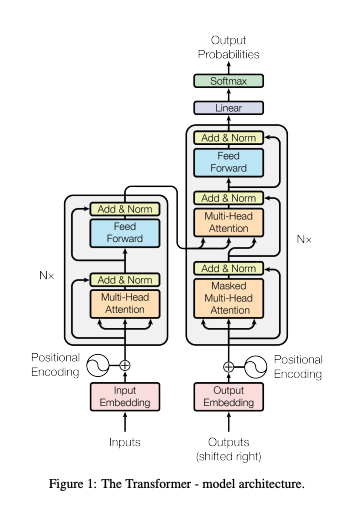

#### Multi-Head Attention

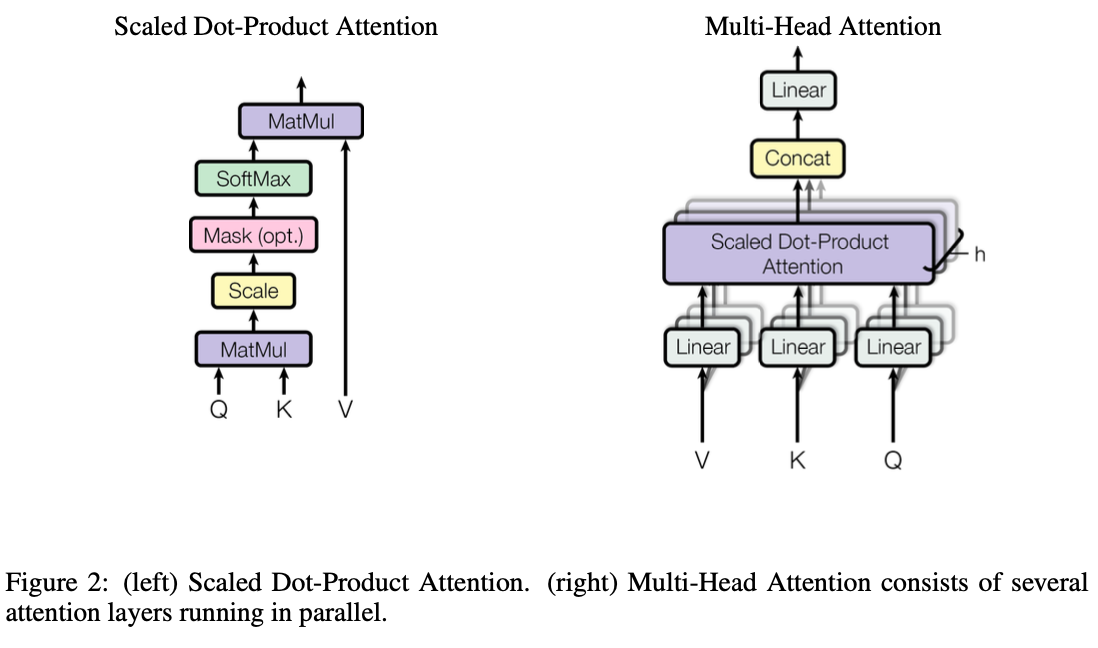

Instead of performing a single attention function with dmodel-dimensional keys, values and queries,
in the artcicle it was mentioned to linearly project the queries, keys and values htimes with different, learned
linear projections to dk , dk and dv dimensions, respectively. On each of these projected versions of
queries, keys and values to perform the attention function in parallel, yielding dv -dimensional
output values. These are concatenated and once again projected, resulting in the final values.
Multi-head attention allows the model to jointly attend to information from different representation
subspaces at different positions. With a single attention head, averaging inhibits this.

$$
\text{MultiHead}(Q,K,V) = \text{Concat}(\text{head}_1, ..., \text{head}_h) W^O
$$

**where**  
$$
\text{head}_i = \text{Attention}(Q W^Q_i ,K W^K_i ,V W^V_i)
$$



**Where the projections are parameter matrices**  
$$
W^Q_i \in \mathbb{R}^{d_{model} \times d_k}, \quad
W^K_i \in \mathbb{R}^{d_{model} \times d_k}, \quad
W^V_i \in \mathbb{R}^{d_{model} \times d_v}, \quad
W^O \in \mathbb{R}^{h d_v \times d_{model}}.
$$
---

In this work we employ \( h = 8 \) parallel attention layers, or heads.  
For each of these we use \( d_k = d_v = d_{model}/h = 64 \).  
Due to the reduced dimension of each head, the total computational cost is similar to that of single-head attention with full dimensionality.



In [ ]:
class PositionalEmbedding(nn.Module):
    """
    Positional Embedding layer that uses sinusoidal functions to add positioning information to the word embeddings of the encoder and decoder.
    """
    def __init__(self, d_model, max_seq_len = MAX_SEQ_LEN):
        """
        Initialize the PositionalEmbedding.

        Parameters:
            d_model (int): Size of the model embeddings
            max_seq_len (int, optional): Maximum sequence length
        """
        super().__init__()
        self.pos_embed_matrix = torch.zeros(max_seq_len, d_model, device=device)
        token_pos = torch.arange(0, max_seq_len, dtype = torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float()
                             * (-math.log(10000.0)/d_model)) # We create this value to be used in a more efficient way
        self.pos_embed_matrix[:, 0::2] = torch.sin(token_pos * div_term)
        self.pos_embed_matrix[:, 1::2] = torch.cos(token_pos * div_term)
        self.pos_embed_matrix = self.pos_embed_matrix.unsqueeze(0).transpose(0,1)

    def forward(self, x):
        """
        Add positional encoding to the input tensor.

        Parameters:
            x (torch.Tensor): Input tensor of shape (seq_len, batch_size, d_model) or a compatible shape
        """
        return x + self.pos_embed_matrix[:x.size(0), :]

class MultiHeadAttention(nn.Module):
    """
    This module implements the multi-head attention mechanism by projecting queries, keys,
    and values into multiple subspaces, computing attention in parallel, and then concatenating the results.
    """
    def __init__(self, d_model = 512, num_heads = 8):
        """
        Initialize the multi-head attention module.

        Parameters:
            d_model (int, optional): Dimensionality of the model
            num_heads (int, optional): Number of attention heads
        """
        super().__init__()
        assert d_model % num_heads == 0, 'Embedding size not compatible with num heads'

        self.d_v = d_model // num_heads
        self.d_k = self.d_v
        self.num_heads = num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, Q, K, V, mask = None):
        """
        Perform a forward pass through the multi-head attention module.

        Parameters:
            Q (torch.Tensor): Query tensor of shape (batch_size, seq_len, d_model)
            K (torch.Tensor): Key tensor of shape (batch_size, seq_len, d_model)
            V (torch.Tensor): Value tensor of shape (batch_size, seq_len, d_model)
            mask (torch.Tensor, optional): Optional mask tensor to prevent attention to certain (future) positions
        """
        batch_size = Q.size(0)
        '''
        Q, K, V -> [batch_size, seq_len, num_heads*d_k]
        after transpose Q, K, V -> [batch_size, num_heads, seq_len, d_k]
        '''
        Q = self.W_q(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2 )
        K = self.W_k(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2 )
        V = self.W_v(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2 )

        weighted_values, attention = self.scale_dot_product(Q, K, V, mask)
        weighted_values = weighted_values.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads*self.d_k)
        weighted_values = self.W_o(weighted_values)

        return weighted_values, attention


    def scale_dot_product(self, Q, K, V, mask = None):
        """
        Compute the scaled dot-product attention.

        Parameters:
            Q (torch.Tensor): Query tensor of shape (batch_size, num_heads, seq_len_q, d_k)
            K (torch.Tensor): Key tensor of shape (batch_size, num_heads, seq_len_k, d_k)
            V (torch.Tensor): Value tensor of shape (batch_size, num_heads, seq_len_v, d_k)
            mask (torch.Tensor, optional): Mask tensor to apply before softmax
        """
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attention = F.softmax(scores, dim = -1)
        weighted_values = torch.matmul(attention, V)

        return weighted_values, attention


class PositionFeedForward(nn.Module):
    """
    Position-wise feed-forward network.
    This module applies two linear transformations with a ReLU activation in between, applied independently to each position.
    """
    def __init__(self, d_model, d_ff):
        """
        Initialize the feed-forward network.

        Parameters:
            d_model (int): Dimensionality of the input and output
            d_ff (int): Dimensionality of the hidden layer
        """
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        """
        Apply the feed-forward network to the input tensor.

        Parameters:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, d_model)
        """
        return self.linear2(F.relu(self.linear1(x)))

class EncoderSubLayer(nn.Module):
    """
    This module encapsulates a single encoder sub-layer which includes a self-attention
    mechanism followed by a feed-forward network. It employs residual connections and layer normalization.
    """
    def __init__(self, d_model, num_heads, d_ff, dropout = 0.1):
        """
        Initialize the encoder sub-layer.

        Parameters:
            d_model (int): Dimensionality of the model
            num_heads (int): Number of attention heads
            d_ff (int): Dimensionality of the feed-forward network
            dropout (float, optional): Dropout probability
        """
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = PositionFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.droupout1 = nn.Dropout(dropout)
        self.droupout2 = nn.Dropout(dropout)

    def forward(self, x, mask = None):
        """
        Perform a forward pass through the encoder sub-layer.

        Parameters:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, d_model)
            mask (torch.Tensor, optional): Attention mask for the self-attention mechanism
        """
        attention_score, _ = self.self_attn(x, x, x, mask) # For the encoder, we use x for the 3 matrixes that generates Queries, keys and values
        x = x + self.droupout1(attention_score)
        x = self.norm1(x)
        x = x + self.droupout2(self.ffn(x))
        return self.norm2(x)

class Encoder(nn.Module):
    """
    This module stacks multiple encoder sub-layers and applies a final layer normalization
    to process the input sequence using self-attention and feed-forward networks.
    """
    def __init__(self, d_model, num_heads, d_ff, num_layers, dropout=0.1):
        """
        Initialize the Encoder module.

        Parameters:
            d_model (int): Size of the model embeddings
            num_heads (int): Number of attention heads
            d_ff (int): Size of the feed-forward network
            num_layers (int): Number of encoder sub-layers
            dropout (float, optional): Dropout probability
        """
        super().__init__()
        self.layers = nn.ModuleList([EncoderSubLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)
    def forward(self, x, mask=None):
        """
        Forward pass of the Encoder module.

        Parameters:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, d_model)
            mask (torch.Tensor, optional): Mask tensor to be applied in each encoder sub-layer
        """
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

class DecoderSubLayer(nn.Module):
    """
    This module comprises one layer of the decoder and includes self-attention, cross-attention with encoder outputs,
    and a feed-forward network. Residual connections and layer normalization are applied after each sub-layer.
    """

    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        """
        Initialize the decoder sub-layer.

        Parameters:
            d_model (int): Dimensionality of the model
            num_heads (int): Number of attention heads
            d_ff (int): Dimensionality of the feed-forward network
            dropout (float, optional): Dropout probability
        """
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, encoder_output, target_mask=None, encoder_mask=None):
        """
        Perform a forward pass through the decoder sub-layer.

        Parameters:
            x (torch.Tensor): Input tensor (target embeddings) of shape (batch_size, target_seq_len, d_model)
            encoder_output (torch.Tensor): Encoder output tensor of shape (batch_size, source_seq_len, d_model)
            target_mask (torch.Tensor, optional): Mask tensor for the target sequence
            encoder_mask (torch.Tensor, optional): Mask tensor for the encoder output
        """
        attention_score, _ = self.self_attn(x, x, x, target_mask)
        x = x + self.dropout1(attention_score)
        x = self.norm1(x)

        encoder_attn, _ = self.cross_attn(x, encoder_output, encoder_output, encoder_mask)
        x = x + self.dropout2(encoder_attn)
        x = self.norm2(x)

        ff_output = self.feed_forward(x)
        x = x + self.dropout3(ff_output)
        return self.norm3(x)

class Decoder(nn.Module):
    """
    This module stacks multiple decoder sub-layers and applies a final layer normalization.
    It processes the target sequence using self-attention, cross-attention with encoder outputs,
    and a feed-forward network.
    """
    def __init__(self, d_model, num_heads, d_ff, num_layers, dropout=0.1):
        """
        Initialize the Decoder module.

        Parameters:
            d_model (int): Size of the model embeddings
            num_heads (int): Number of attention heads
            d_ff (int): Size of the feed-forward network
            num_layers (int): Number of decoder sub-layers
            dropout (float, optional): Dropout probability
        """
        super().__init__()
        self.layers = nn.ModuleList([DecoderSubLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, encoder_output, target_mask, encoder_mask):
        """
        Perform a forward pass through the Decoder module.

        Parameters:
            x (torch.Tensor): Input tensor (target embeddings) of shape (batch_size, target_seq_len, d_model)
            encoder_output (torch.Tensor): Encoder output tensor of shape (batch_size, source_seq_len, d_model)
            target_mask (torch.Tensor): Mask tensor for the target sequence
            encoder_mask (torch.Tensor): Mask tensor for the encoder output
        """
        for layer in self.layers:
            x = layer(x, encoder_output, target_mask, encoder_mask)
        return self.norm(x)

In [ ]:
class Transformer(nn.Module):
    """
    This model consists of an encoder and a decoder with corresponding embedding layers
    and positional encodings. It leverages self-attention mechanisms and feed-forward
    networks in both the encoder and the decoder. The decoder additionally uses a causal
    mask to ensure autoregressive behavior during training and inference.

    Attributes:
        encoder_embedding (nn.Embedding): Embedding layer for the source sequence
        decoder_embedding (nn.Embedding): Embedding layer for the target sequence
        pos_embedding (PositionalEmbedding): Positional embedding layer to inject token position information
        encoder (Encoder): Encoder module composed of multiple encoder layers
        decoder (Decoder): Decoder module composed of multiple decoder layers
        output_layer (nn.Linear): Linear layer used after the decoder (before softmax, which is used after training the model)
    """
    def __init__(self, d_model, num_heads, d_ff, num_layers,
                 input_vocab_size, target_vocab_size,
                 max_len=MAX_SEQ_LEN, dropout=0.1):
        """
        Initialize the Transformer model.

        Parameters:
            d_model (int): Size (Dimensionality) of the model embeddings
            num_heads (int): Number of attention heads that are going to run in parallel
            d_ff (int): Size (Dimensionality) of the feed-forward network
            num_layers (int): Number of encoder and decoder layers
            input_vocab_size (int): Size of the input vocabulary. For our example below, this is the size of the vocabulary in English
            target_vocab_size (int): Size of the target vocabulary. For our example below, this is the size of the vocabulary in Spanish
            max_len (int, optional): Maximum sequence length for positional encoding. This is the maximum tokens in a sentence
            dropout (float, optional): Dropout probability. Used before normalization
        """
        super().__init__()
        self.encoder_embedding = nn.Embedding(input_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(target_vocab_size, d_model)
        self.pos_embedding = PositionalEmbedding(d_model, max_len)
        self.encoder = Encoder(d_model, num_heads, d_ff, num_layers, dropout)
        self.decoder = Decoder(d_model, num_heads, d_ff, num_layers, dropout)
        self.output_layer = nn.Linear(d_model, target_vocab_size)

    def forward(self, source, target):
        """
        Execute a forward pass through the Transformer model.

        This method applies the embedding and positional encoding to both the source
        and target sequences, generates appropriate masks, and then processes the inputs
        through the encoder and decoder. The final output is projected to the target vocabulary.

        Parameters:
            source (torch.Tensor): Tensor of shape (batch_size, source_seq_len) containing source token indices. For our example, this is the source language
            target (torch.Tensor): Tensor of shape (batch_size, target_seq_len) containing target token indices. For our example, this is the target language
        """
        # Encoder mask
        source_mask, target_mask = self.mask(source, target)
        # Embedding and positional Encoding
        source = self.encoder_embedding(source) * math.sqrt(self.encoder_embedding.embedding_dim) # Following the paper, they multiply the embeddings by the square root of d_model
        source = self.pos_embedding(source)
        # Encoder
        encoder_output = self.encoder(source, source_mask)

        # Decoder embedding and postional encoding
        target = self.decoder_embedding(target) * math.sqrt(self.decoder_embedding.embedding_dim)  # Following the paper, they multiply the embeddings by the square root of d_model
        target = self.pos_embedding(target)
        # Decoder
        output = self.decoder(target, encoder_output, target_mask, source_mask)

        return self.output_layer(output)



    def mask(self, source, target):
        """
        Generate masks for the source and target sequences.

        The source mask prevents the encoder from attending to future tokens or to padding tokens.
        The target mask prevents the decoder from attending to future tokens or to padding tokens.

        We say that 0 represents padding tokens and other values are for tokens that represent words (or valid tokens)
        or special tokens (eg. start or end of sequence).

        Parameters:
            source (torch.Tensor): Tensor of shape (batch_size, source_seq_len) containing source token indices
            target (torch.Tensor): Tensor of shape (batch_size, target_seq_len) containing target token indices
        """
        source_mask = (source != 0).unsqueeze(1).unsqueeze(2)
        target_mask = (target != 0).unsqueeze(1).unsqueeze(2)
        size = target.size(1)
        no_mask = torch.tril(torch.ones((1, size, size), device=device)).bool() # Using a triangular matrix with 0s (zeros) in the upper triangle and 1s in the lower one.
        target_mask = target_mask & no_mask
        return source_mask, target_mask


## Simple test

In [ ]:
# Assuming sentences of 10 words (tokens) for the source and target
seq_len_source = 10
seq_len_target = 10

batch_size = 2
input_vocab_size = 50
target_vocab_size = 50

# Next, we simulate "sentences" using random numbers from 1 to 50, each with 10 values ("words")
source = torch.randint(1, input_vocab_size, (batch_size, seq_len_source))
target = torch.randint(1, target_vocab_size, (batch_size, seq_len_target))

In [ ]:
# Let's use the same values from the paper Attention is all you need
d_model = 512
num_heads = 8
d_ff = 2048
num_layers = 6

# Instanciating the model
model = Transformer(d_model, num_heads, d_ff, num_layers,
                  input_vocab_size, target_vocab_size,
                  max_len=MAX_SEQ_LEN, dropout=0.1)

# Move everything to the GPU
model = model.to(device)
source = source.to(device)
target = target.to(device)

In [ ]:
# Run the model
output = model(source, target)

In [ ]:
# Expected output shape -> [batch, seq_len_target, target_vocab_size] i.e. [2, 10, 50]
print(f'ouput.shape {output.shape}')

ouput.shape torch.Size([2, 10, 50])


## Translator Eng-Spa

In [ ]:
PATH = '/content/drive/MyDrive/Colab Notebooks/MNA/TC5033 - Advance ML Methods/Week 9/Activity 4/eng-spa4.txt'

In [ ]:
with open(PATH, 'r', encoding='utf-8') as f:
    lines = f.readlines()
eng_spa_pairs = [line.strip().split('\t') for line in lines if '\t' in line] # Read the pairs in each line, split it using tab

In [ ]:
eng_spa_pairs[:10]

[['Hi.', 'Hola.'],
 ['So?', '¿Entonces?'],
 ['Go!', 'Váyase'],
 ['Go!', 'Vete'],
 ['Ok!', '¡OK!'],
 ['Ah!', '¡Anda!'],
 ['So?', '¿Y qué?'],
 ['Ow!', '¡Ay!'],
 ['No!', '¡No!'],
 ['No.', 'No.']]

In [ ]:
eng_sentences = [pair[0] for pair in eng_spa_pairs]
spa_sentences = [pair[1] for pair in eng_spa_pairs]

In [ ]:
print(eng_sentences[:10])
print(spa_sentences[:10])

['Hi.', 'So?', 'Go!', 'Go!', 'Ok!', 'Ah!', 'So?', 'Ow!', 'No!', 'No.']
['Hola.', '¿Entonces?', 'Váyase', 'Vete', '¡OK!', '¡Anda!', '¿Y qué?', '¡Ay!', '¡No!', 'No.']


### Preprocessing sentences

In [ ]:
def preprocess_sentence(sentence):
    """
    Preprocess each sentence so:
    (1) It replaces multiple spaces with just one space
    (2) It removes accent mark from vocals
    (3) It replaces all characters different than letters from a to z with one space
    (4) It removes spaces at the beginning and the end of the senteces
    (5) It adds <sos> (start of sequence) at the beggining of the sentences and <eos> (end of sequence) at the end

    Parameters:
        sentence (string): Sentence on a certain language (source or target)
    """
    sentence = sentence.lower().strip()
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[á]+", "a", sentence)
    sentence = re.sub(r"[é]+", "e", sentence)
    sentence = re.sub(r"[í]+", "i", sentence)
    sentence = re.sub(r"[ó]+", "o", sentence)
    sentence = re.sub(r"[ú]+", "u", sentence)
    sentence = re.sub(r"[^a-z]+", " ", sentence)
    sentence = sentence.strip()
    sentence = '<sos> ' + sentence + ' <eos>'
    return sentence

In [ ]:
s1 = '¿Hola @ cómo estás? 123'

In [ ]:
print(s1)
print(preprocess_sentence(s1))

¿Hola @ cómo estás? 123
<sos> hola como estas <eos>


In [ ]:
eng_sentences = [preprocess_sentence(sentence) for sentence in eng_sentences]
spa_sentences = [preprocess_sentence(sentence) for sentence in spa_sentences]

In [ ]:
spa_sentences[:10]

['<sos> hola <eos>',
 '<sos> entonces <eos>',
 '<sos> vayase <eos>',
 '<sos> vete <eos>',
 '<sos> ok <eos>',
 '<sos> anda <eos>',
 '<sos> y que <eos>',
 '<sos> ay <eos>',
 '<sos> no <eos>',
 '<sos> no <eos>']

### Building vocabulary

In [ ]:
def build_vocab(sentences):
    """
    Builds a vocabulary with all the words used in all sentences.

    Parameters:
        sentences (list[str]): Sentence on a certain language (source or target)
    """
    words = [word for sentence in sentences for word in sentence.split()]
    word_count = Counter(words)
    sorted_word_counts = sorted(word_count.items(), key=lambda x:x[1], reverse=True) # We sorted using most repeated words first
    word2idx = {word: idx for idx, (word, _) in enumerate(sorted_word_counts, 2)} # We start the index with 2, because 0 and 1 will be for padding and unknown
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1
    idx2word = {idx: word for word, idx in word2idx.items()}
    return word2idx, idx2word

In [ ]:
eng_word2idx, eng_idx2word = build_vocab(eng_sentences)
spa_word2idx, spa_idx2word = build_vocab(spa_sentences)
eng_vocab_size = len(eng_word2idx)
spa_vocab_size = len(spa_word2idx)

In [ ]:
print(eng_vocab_size, spa_vocab_size) # We notice that vocabilaries are of different sizes for each language, which makes sense

27933 47339


### Creating our own Dataset and training the model

In [ ]:
class EngSpaDataset(Dataset):
    """
    A dataset for handling parallel English-Spanish sentences.

    This dataset stores pairs of English and Spanish sentences and converts them into sequences of word indices
    using provided vocabulary mappings.
    """
    def __init__(self, eng_sentences, spa_sentences, eng_word2idx, spa_word2idx):
        """
        Initializes the EngSpaDataset with parallel sentences and their corresponding vocabularies.

        Args:
            eng_sentences (list[str]): A list of English sentences
            spa_sentences (list[str]): A list of Spanish sentences
            eng_word2idx (dict): A dictionary mapping English words to their corresponding indices
            spa_word2idx (dict): A dictionary mapping Spanish words to their corresponding indices
        """
        self.eng_sentences = eng_sentences
        self.spa_sentences = spa_sentences
        self.eng_word2idx = eng_word2idx
        self.spa_word2idx = spa_word2idx

    def __len__(self):
        """
        Returns the total number of sentence pairs in the dataset

        Returns:
            int: The number of sentence pairs
        """
        return len(self.eng_sentences)

    def __getitem__(self, idx):
        """
        Retrieves the sentence pair at the specified index and converts each sentence to a tensor of word indices.

        Each sentence is split on whitespace, and each word is replaced by its corresponding index from the
        vocabulary. If a word is not found in the vocabulary, the index for the '<unk>' (unknown) token is used.

        Args:
            idx (int): The index of the sentence pair to retrieve
        """
        eng_sentence = self.eng_sentences[idx]
        spa_sentence = self.spa_sentences[idx]
        # return tokens idxs
        eng_idxs = [self.eng_word2idx.get(word, self.eng_word2idx['<unk>']) for word in eng_sentence.split()]
        spa_idxs = [self.spa_word2idx.get(word, self.spa_word2idx['<unk>']) for word in spa_sentence.split()]

        return torch.tensor(eng_idxs), torch.tensor(spa_idxs)

In [ ]:
def collate_fn(batch):
    """
    This function will be passed to the DataLoader to add the padding.

    This function takes a list of tuples containing English and Spanish sentence tensors.
    Each sentence tensor is first truncated to a maximum length defined by MAX_SEQ_LEN, then cloned and detached from its computation graph.
    Finally, the sequences are padded (using PyTorch's pad_sequence function) so that all sequences in each batch have the same length.

    Args:
        batch (List[Tuple[torch.Tensor, torch.Tensor]]): A list of tuples, where each tuple contains
            two tensors: the first tensor is the English sentence and the second tensor is the Spanish sentence.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: A tuple containing two tensors:
            - The first tensor is the padded batch of English sentence tensors
            - The second tensor is the padded batch of Spanish sentence tensors
    """
    eng_batch, spa_batch = zip(*batch)
    eng_batch = [seq[:MAX_SEQ_LEN].clone().detach() for seq in eng_batch] # We truncate the sequence to our sequence length
    spa_batch = [seq[:MAX_SEQ_LEN].clone().detach() for seq in spa_batch] # We truncate the sequence to our sequence length
    eng_batch = torch.nn.utils.rnn.pad_sequence(eng_batch, batch_first=True, padding_value=0)
    spa_batch = torch.nn.utils.rnn.pad_sequence(spa_batch, batch_first=True, padding_value=0)
    return eng_batch, spa_batch


In [ ]:
def train(model, dataloader, loss_function, optimiser, epochs):
    """
    Trains the model using the provided dataloader, loss function, and optimiser over a specified number of epochs.

    This function sets the model to training mode, then iterates over the dataset for the given number of epochs.
    For each batch, it moves the data to the appropriate device, preprocesses the Spanish sentence
    batch for decoder inputs and targets using teacher forcing (i.e., shifting the sequence by one),
    performs a forward pass through the model, computes the loss, and updates the model parameters via backpropagation.

    Args:
        model (torch.nn.Module): The sequence-to-sequence model to be trained
        dataloader (torch.utils.data.DataLoader): DataLoader yielding batches of input data
            Each batch should be a tuple (eng_batch, spa_batch), where:
                - eng_batch (torch.Tensor): Batch of English sentence tensors
                - spa_batch (torch.Tensor): Batch of Spanish sentence tensors
        loss_function (callable): The loss function to compute the difference between the model predictions and the target outputs
        optimiser (torch.optim.Optimizer): The optimizer used to update the model parameters
        epochs (int): The number of epochs to train the model
    """
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for i, (eng_batch, spa_batch) in enumerate(dataloader):
            eng_batch = eng_batch.to(device)
            spa_batch = spa_batch.to(device)
            # Decoder preprocessing
            target_input = spa_batch[:, :-1] # Spanish batch without the last token (<eos>)
            target_output = spa_batch[:, 1:].contiguous().view(-1) # Spanish batch without the first token (), reshaped to a 1D tensor for loss computation
            # Zero grads
            optimiser.zero_grad()
            # run model
            output = model(eng_batch, target_input)
            output = output.view(-1, output.size(-1)) # We make this reshape so it's compatible with our loss function
            # loss\
            loss = loss_function(output, target_output)
            # gradient and update parameters
            loss.backward()
            optimiser.step()
            total_loss += loss.item()

        avg_loss = total_loss/len(dataloader)
        print(f'Epoch: {epoch}/{epochs}, Loss: {avg_loss:.4f}')



In [ ]:
# Define the batch size for training
BATCH_SIZE = 64  # Number of sentence pairs processed in parallel during training

# Create the dataset object with English and Spanish sentences
dataset = EngSpaDataset(eng_sentences, spa_sentences, eng_word2idx, spa_word2idx)

# Create a DataLoader to load data in batches
dataloader = DataLoader(
    dataset,              # The dataset containing English-Spanish sentence pairs
    batch_size=BATCH_SIZE, # Number of samples processed per batch (64 in this case)
    shuffle=True,         # Randomly shuffles the dataset at every epoch to improve learning
    collate_fn=collate_fn # Function to handle padding and batch formatting
)

#### Instanciating the model

In [ ]:
# Creating a Transformer with specific values
model = Transformer(
    d_model=512,             # Dimension of the embedding vectors and internal representations (size of each token in the network)
    num_heads=8,             # Number of multi-head attention heads (divides the representation into 8 parts for parallel processing)
    d_ff=2048,               # Dimension of the feed-forward layer in each Transformer block (controls the network's capacity)
    num_layers=6,            # Number of layers in the encoder and decoder (6 layers in each, as in the original Vaswani et al. model)
    input_vocab_size=eng_vocab_size,  # Input vocabulary size (number of tokens in English)
    target_vocab_size=spa_vocab_size, # Output vocabulary size (number of tokens in Spanish)
    max_len=MAX_SEQ_LEN,     # Maximum sequence length (defines how many tokens the model can process in a sentence)
    dropout=0.1              # Dropout rate (a technique to reduce overfitting, 0.1 means 10% of the units are randomly deactivated during training)
)

In [ ]:
model = model.to(device)
loss_function = nn.CrossEntropyLoss(ignore_index=0) # We use ignore_index so it doesn't account padding characters for the loss
optimiser = optim.Adam(model.parameters(), lr=0.0001)

#### Training the model

In [ ]:
train(model, dataloader, loss_function, optimiser, epochs = 20) # Run in approx. 90mins using A100 GPU

Epoch: 0/20, Loss: 3.5791
Epoch: 1/20, Loss: 2.1904
Epoch: 2/20, Loss: 1.6929
Epoch: 3/20, Loss: 1.3690
Epoch: 4/20, Loss: 1.1207


In [ ]:
def sentence_to_indices(sentence, word2idx):
    """
    Convert a sentence into a list of word indices using a vocabulary mapping.

    Each word in the sentence is split by whitespace and mapped to its corresponding index.
    If a word is not found in the mapping, the index for the '<unk>' token is used.

    Args:
        sentence (str): The input sentence to convert
        word2idx (dict): A dictionary mapping words to their indices

    Returns:
        list[int]: A list of integers representing the word indices for the sentence
    """
    return [word2idx.get(word, word2idx['<unk>']) for word in sentence.split()]

def indices_to_sentence(indices, idx2word):
    """
    Convert a list of word indices back into a sentence string using an index-to-word mapping. (Basically the reverse of the previous function)

    Words corresponding to padding tokens ('<pad>') are omitted from the resulting sentence.

    Args:
        indices (list[int]): A list of word indices
        idx2word (dict): A dictionary mapping indices to words

    Returns:
        str: The reconstructed sentence
    """
    return ' '.join([idx2word[idx] for idx in indices if idx in idx2word and idx2word[idx] != '<pad>'])

def translate_sentence(model, sentence, eng_word2idx, spa_idx2word, max_len=MAX_SEQ_LEN, device='cpu'):
    """
    Translate an English sentence to Spanish using the provided model.

    The function preprocesses the input sentence, converts it to indices, and employs a greedy decoding approach to generate the translation.
    The translation generation starts with the start-of-sequence token and continues until the end-of-sequence token is produced
    or the maximum sequence length is reached.

    Args:
        model (torch.nn.Module): The trained translation model
        sentence (str): The English sentence to translate
        eng_word2idx (dict): A dictionary mapping English words to indices
        spa_idx2word (dict): A dictionary mapping Spanish indices to words
        max_len (int, optional): The maximum length of the generated sentence. Defaults to MAX_SEQ_LEN
        device (str or torch.device, optional): The device on which to perform translation

    Returns:
        str: The translated Spanish sentence
    """
    model.eval()
    sentence = preprocess_sentence(sentence)
    input_indices = sentence_to_indices(sentence, eng_word2idx)
    input_tensor = torch.tensor(input_indices).unsqueeze(0).to(device)

    # Initialize the target tensor with <sos> token
    tgt_indices = [spa_word2idx['<sos>']]
    tgt_tensor = torch.tensor(tgt_indices).unsqueeze(0).to(device)

    # Here we get the predicted indices
    with torch.no_grad():
        for _ in range(max_len):
            output = model(input_tensor, tgt_tensor)
            output = output.squeeze(0)
            next_token = output.argmax(dim=-1)[-1].item()
            tgt_indices.append(next_token)
            tgt_tensor = torch.tensor(tgt_indices).unsqueeze(0).to(device)
            if next_token == spa_word2idx['<eos>']:
                break

    return indices_to_sentence(tgt_indices, spa_idx2word)

In [ ]:
def evaluate_translations(model, sentences, eng_word2idx, spa_idx2word, max_len=MAX_SEQ_LEN, device='cpu'):
    """
    Evaluate and print translations for a list of English sentences using the translation model.

    For each sentence in the input list, this function generates its Spanish translation by calling the 'translate_sentence' function,
    then prints both the original sentence and its translation.

    Args:
        model (torch.nn.Module): The trained translation model
        sentences (list[str]): A list of English sentences to translate
        eng_word2idx (dict): A dictionary mapping English words to indices
        spa_idx2word (dict): A dictionary mapping Spanish indices to words
        max_len (int, optional): The maximum length for translation generation. Defaults to MAX_SEQ_LEN
        device (str or torch.device, optional): The device on which to perform translation
    """
    for sentence in sentences:
        translation = translate_sentence(model, sentence, eng_word2idx, spa_idx2word, max_len, device)
        print(f'Input sentence: {sentence}')
        print(f'Traducción: {translation}')
        print()

# Example sentences to test the translator
test_sentences = [
    "Hello, how are you?",
    "I am learning artificial intelligence.",
    "Artificial intelligence is great.",
    "Good night!",
    "Artificial intelligence is a complex topic",
    "Studying maths is fun",
    "I live in Mexico",
    "Divide and conquer",
    "Do you remember my name?",
    "This film is too long"
]

# Assuming the model is trained and loaded
# Set the device to 'cpu' or 'cuda' as needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Evaluate translations
evaluate_translations(model, test_sentences, eng_word2idx, spa_idx2word, max_len=MAX_SEQ_LEN, device=device)


Input sentence: Hello, how are you?
Traducción: <sos> hola como estas <eos>

Input sentence: I am learning artificial intelligence.
Traducción: <sos> estoy aprendiendo inteligencia artificial <eos>

Input sentence: Artificial intelligence is great.
Traducción: <sos> la inteligencia artificial es genial <eos>

Input sentence: Good night!
Traducción: <sos> buenas noches <eos>

Input sentence: Artificial intelligence is a complex topic
Traducción: <sos> la inteligencia artificial es un complejo pensamiento <eos>

Input sentence: Studying maths is fun
Traducción: <sos> estudiar las matematicas es divertido <eos>

Input sentence: I live in Mexico
Traducción: <sos> vivo en mexico <eos>

Input sentence: Divide and conquer
Traducción: <sos> divide y venceras <eos>

Input sentence: Do you remember my name?
Traducción: <sos> recuerdas mi nombre <eos>

Input sentence: This film is too long
Traducción: <sos> esta pelicula es demasiado larga <eos>



# Conclusion

## **The Transformer Model and Its Impact on NLP**  

The **Transformer** model, introduced in the paper *"Attention Is All You Need"*, has revolutionized the field of **Natural Language Processing (NLP)**.  
Its architecture, based on **self-attention**, eliminates the need for sequential structures like recurrent neural networks (RNNs), allowing it to process entire sentences in parallel and capture long-range dependencies between words.

---

### **Observations During the Transformer Implementation for English-Spanish Translation**  

During this exercise, we identified key aspects affecting performance:

1. **Computational Complexity**  
   - The **self-attention mechanism** scales quadratically with the sequence length, making the Transformer **computationally expensive**.

2. **Batch Size and Training Time**  
   - **Larger batch sizes** allow the model to process more samples in parallel, accelerating training.  
   - However, **memory constraints** in the GPU limit the maximum batch size.

3. **Tokenization and Morphology Handling**  
   - In this exercise, the Transformer represents each word as a **single token**, which is **not optimal** for languages with **complex morphology** (e.g., Spanish).  
   - This leads to **reduced translation accuracy**, as word-based tokenization fails to capture subword-level variations.

---

### **Expanding Applications of the Transformer Model**  

Beyond translation, this model enables a wide range of applications, including:  

**Chatbots & Virtual Assistants**
**Machine Translation**
**Automated Customer Support**
**Speech Recognition & Text-to-Speech**
**Text Summarization & Document Analysis**
**Sentiment Analysis & Opinion Mining**
**Content Generation (e.g., GPT models)**

Its ability to understand and generate human-like text makes it **invaluable in AI-driven communication and language processing tasks**.

---

### **Final Thoughts**  

The **Transformer is not the end of the journey**, but rather a **starting point** for even more advanced and scalable architectures in NLP.  
Future models will continue to refine **efficiency, adaptability, and accuracy**, pushing the boundaries of what AI can achieve in language understanding.


# References

Dhanani, F., Rafi, M., & Tahir, M. (2025). Tickling translations: Small but mighty open-sourced transformers bring English PUN-ny entities to life in French!. Computer Speech & Language, 90, 1-15. https://doi.org/10.1016/j.csl.2024.101739.

Kumar, S. (2025). Advancements in medical image segmentation: A review of transformer models. *Computers and Electrical Engineering*, *123*, 1-51. https://doi.org/10.1016/j.compeleceng.2025.110099.

Tian, T., Song, C., Ting, J., & Huang, H. (2022). A French-to-English Machine Translation Model Using Transformer Network. *Procedia Computer Science*, *199*, 1438-1443. https://doi.org/10.1016/j.procs.2022.01.182.

Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, Ł., & Polosukhin, I. (2017). Attention is all you need. *Advances in Neural Information Processing Systems*, *30*, 5998–6008. https://doi.org/10.48550/arXiv.1706.03762.